Importation des library

In [1]:
import pandas as pd
import numpy as np
import vectorbt as vbt
import matplotlib.pyplot as plt
import anywidget
import os
from pathlib import Path

plt.style.use('dark_background')

Chargement des données

In [2]:
symbol = ['ETHUSDT']
time = "5m"
chemin = r'C:\Users\gunsa\Desktop\Git-Repo\Bot-Trading\Data\ETHUSDT_365d_2021-01-01_TO_2025-12-17_5m_data.parquet'
data = pd.read_parquet(chemin)

Mise en forme des données

In [3]:
# Agencement des données + index + mis à l'heure de paris
df_raw = data.get(['Close','Open','High','Low','Volume']).copy()
df_raw.tail()

,Close,Open,High,Low,Volume
521583,1.8764,1.8729,1.8798,1.8723,390848.5
521584,1.8797,1.8764,1.8822,1.8754,178496.1
521585,1.8767,1.8797,1.8797,1.8752,141896.8
521586,1.8737,1.8766,1.8766,1.8706,433959.4
521587,1.8792,1.8736,1.8802,1.8724,171822.6


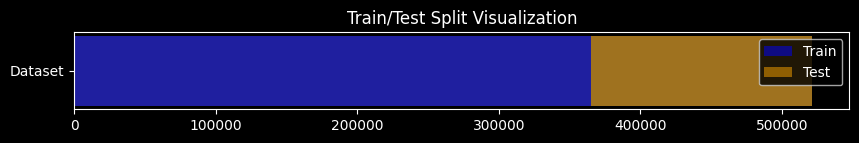

In [4]:
# Separation des données en train et test (IS/OOS) (70/30%)
split_idx = int(0.7*len(df_raw))
train_data = df_raw.iloc[:split_idx]
test_data = df_raw.iloc[split_idx:]

# Affichage de la séparation des données
plt.figure(figsize=(10, 1))
plt.barh(['Dataset'], [len(df_raw)], color='lightgray', alpha=0.3)
plt.barh(['Dataset'], [split_idx], color='blue', alpha=0.5, label='Train')
plt.barh(['Dataset'], [len(df_raw)-split_idx], left=split_idx, color='orange', alpha=0.5, label='Test')
plt.title('Train/Test Split Visualization')
plt.legend()
plt.show()

In [5]:
# Selection du train_set comme données d'entrainement
df = df_raw.copy()

In [ ]:
import vectorbt as vbt
import plotly.graph_objects as go
import pandas as pd
import numpy as np
from itertools import product

# ================================================
# 0) Configuration des paramètres à tester
# ================================================
windows = [9, 20, 21, 50, 200]
tp_multipliers = [1.5, 2, 2.5, 3]
sl_multipliers = [1.5, 2, 2.5, 3]

# ================================================
# 1) Préparation des données
# ================================================
close = df['Close']
results = []

# Calcul de toutes les moyennes mobiles nécessaires
ma_cache = {}
for window in windows:
    # SMA
    ma_cache[(window, 'sma')] = vbt.MA.run(close, window=window).ma
    # EMA
    ma_cache[(window, 'ema')] = vbt.MA.run(close, window=window, ewm=True).ma

# ================================================
# 2) ATR (calculé une seule fois)
# ================================================
atr = vbt.ATR.run(
    high=df['High'],
    low=df['Low'],
    close=close,
    window=5
).atr

# ================================================
# 3) Boucle de test sur TOUTES les combinaisons
# ================================================
# Générer toutes les combinaisons de fenêtres (court/long)
window_pairs = [(short, long) for short in windows for long in windows if short < long]

# Générer toutes les combinaisons de types (court_type/long_type)
type_combinations = [('sma', 'sma'), ('sma', 'ema'), ('ema', 'sma'),('ema', 'ema')]

total_combinations = len(window_pairs) * len(type_combinations) * len(tp_multipliers) * len(sl_multipliers)
print(f"Nombre total de combinaisons à tester: {total_combinations}")
print("Début du backtest...")

compteur = 0

for short_window, long_window in window_pairs:
    for short_type, long_type in type_combinations:
        # Récupération des moyennes mobiles depuis le cache
        ma_short = ma_cache[(short_window, short_type)]
        ma_long = ma_cache[(long_window, long_type)]
        
        # Filtre de range basé sur l'ATR
        atr_mean = atr.rolling(40).mean()
        range_filter = atr > atr_mean
        
        # Signaux d'entrée et de sortie
        long_entries = (ma_short.vbt.crossed_above(ma_long)) & range_filter
        long_exits = ma_short.vbt.crossed_below(ma_long)
        short_entries = (ma_short.vbt.crossed_below(ma_long)) & range_filter
        short_exits = ma_short.vbt.crossed_above(ma_long)
        
        # Test des différents multiplicateurs TP/SL
        for tp_mult, sl_mult in product(tp_multipliers, sl_multipliers):
            tp_atr = tp_mult * atr / close
            sl_atr = sl_mult * atr / close
            
            # Vérifier s'il y a des signaux
            if not (long_entries.any() or short_entries.any()):
                continue
            
            # Backtest
            pf = vbt.Portfolio.from_signals(
                close,
                entries=long_entries,
                exits=long_exits,
                short_entries=short_entries,
                short_exits=short_exits,
                tp_stop=tp_atr,
                sl_stop=sl_atr,
                init_cash=500,
                fees=0.0004,
                slippage=0.0002,
                freq=time
            )
            
            # Récupération des statistiques
            stats = pf.stats()
            trades = pf.trades.records_readable
            
            # Statistiques par direction
            def stats_by_direction(trades, direction_name):
                t = trades[trades['Direction'] == direction_name]
                if len(t) == 0:
                    return {
                        "direction": direction_name,
                        "trades": 0,
                        "wins": 0,
                        "losses": 0,
                        "winrate_%": 0,
                        "total_pnl": 0,
                        "avg_pnl": 0
                    }
                
                wins = t[t['PnL'] > 0]
                
                return {
                    "direction": direction_name,
                    "trades": len(t),
                    "wins": len(wins),
                    "losses": len(t) - len(wins),
                    "winrate_%": round(len(wins) / len(t) * 100, 2) if len(t) > 0 else 0,
                    "total_pnl": round(t['PnL'].sum(), 2),
                    "avg_pnl": round(t['PnL'].mean(), 2)
                }
            
            long_stats = stats_by_direction(trades, "Long")
            short_stats = stats_by_direction(trades, "Short")
            
            # Stockage des résultats
            results.append({
                'short_window': short_window,
                'long_window': long_window,
                'short_type': short_type.upper(),
                'long_type': long_type.upper(),
                'tp_multiplier': tp_mult,
                'sl_multiplier': sl_mult,
                'total_return': stats['Total Return [%]'],
                'sharpe_ratio': stats['Sharpe Ratio'],
                'win_rate': stats['Win Rate [%]'],
                'max_drawdown': stats['Max Drawdown [%]'],
                'total_trades': stats['Total Trades'],
                'long_trades': long_stats['trades'],
                'short_trades': short_stats['trades'],
                'long_winrate': long_stats['winrate_%'],
                'short_winrate': short_stats['winrate_%'],
                'total_pnl': long_stats['total_pnl'] + short_stats['total_pnl'],
                'strategy_name': f"{short_type.upper()}{short_window}/{long_type.upper()}{long_window}"
            })
            
            compteur += 1
            if compteur % 100 == 0:
                print(f"Progression: {compteur}/{total_combinations} combinaisons testées")

print(f"\nBacktest terminé! {compteur} combinaisons testées.")

# ================================================
# 4) Analyse des résultats
# ================================================
results_df = pd.DataFrame(results)

# Filtrer les stratégies avec un nombre minimum de trades
min_trades = 5
results_df = results_df[results_df['total_trades'] >= min_trades]

if len(results_df) == 0:
    print(f"Aucune stratégie n'a généré au moins {min_trades} trades. Réduisez le seuil.")
    # Réduire le seuil
    results_df = pd.DataFrame(results)
    results_df = results_df[results_df['total_trades'] > 0]

# Trier par meilleur rendement total
results_df = results_df.sort_values('total_return', ascending=False)

# Afficher nom du dataset
nomDataSet = Path(chemin).stem
print(f"DATASET : {nomDataSet}")

print("\n" + "=" * 80)
print("TOP 20 DES MEILLEURES COMBINAISONS")
print("=" * 80)

# Afficher les meilleures combinaisons
for i, row in results_df.head(20).iterrows():
    strategy_desc = f"{row['short_type']}{row['short_window']}/{row['long_type']}{row['long_window']}"
    print(f"{i+1:2d}. {strategy_desc:15s} | "
          f"TP:{row['tp_multiplier']} SL:{row['sl_multiplier']} | "
          f"Return: {row['total_return']:7.2f}% | "
          f"Sharpe: {row['sharpe_ratio']:5.2f} | "
          f"WinRate: {row['win_rate']:5.1f}% | "
          f"Trades: {row['total_trades']:3d}")

# ================================================
# 5) Analyse par type de combinaison
# ================================================
print("\n" + "=" * 80)
print("ANALYSE PAR TYPE DE COMBINAISON")
print("=" * 80)

# Ajouter une colonne pour le type de combinaison
results_df['combo_type'] = results_df.apply(
    lambda x: f"{x['short_type']}/{x['long_type']}", axis=1
)

# Statistiques par type de combinaison
for combo_type in ['SMA/SMA', 'SMA/EMA', 'EMA/SMA', 'EMA/EMA']:
    subset = results_df[results_df['combo_type'] == combo_type]
    if len(subset) > 0:
        avg_return = subset['total_return'].mean()
        best_return = subset['total_return'].max()
        best_strategy = subset.loc[subset['total_return'].idxmax(), 'strategy_name']
        print(f"{combo_type:10s}: {len(subset):4d} combinaisons | "
              f"Retour moyen: {avg_return:6.2f}% | "
              f"Meilleur: {best_return:6.2f}% ({best_strategy})")

# ================================================
# 6) Utiliser la meilleure combinaison pour le graphique
# ================================================
if len(results_df) > 0:
    best = results_df.iloc[0]
    print("\n" + "=" * 80)
    print(f"MEILLEURE COMBINAISON: {best['short_type']}{best['short_window']}/{best['long_type']}{best['long_window']}")
    print(f"avec TP={best['tp_multiplier']}x et SL={best['sl_multiplier']}x")
    print("=" * 80)

    # Recréation de la meilleure combinaison pour le graphique
    if best['short_type'] == 'EMA':
        ma_short = vbt.MA.run(close, window=best['short_window'], ewm=True).ma
    else:
        ma_short = vbt.MA.run(close, window=best['short_window']).ma
    
    if best['long_type'] == 'EMA':
        ma_long = vbt.MA.run(close, window=best['long_window'], ewm=True).ma
    else:
        ma_long = vbt.MA.run(close, window=best['long_window']).ma

    # Filtre de range
    atr_mean = atr.rolling(40).mean()
    range_filter = atr > atr_mean

    # Signaux
    long_entries = (ma_short.vbt.crossed_above(ma_long)) & range_filter
    long_exits = ma_short.vbt.crossed_below(ma_long)
    short_entries = (ma_short.vbt.crossed_below(ma_long)) & range_filter
    short_exits = ma_short.vbt.crossed_above(ma_long)

    # TP/SL
    tp_atr = best['tp_multiplier'] * atr / close
    sl_atr = best['sl_multiplier'] * atr / close

    # Backtest final avec la meilleure combinaison
    best_pf = vbt.Portfolio.from_signals(
        close,
        entries=long_entries,
        exits=long_exits,
        short_entries=short_entries,
        short_exits=short_exits,
        tp_stop=tp_atr,
        sl_stop=sl_atr,
        init_cash=500,
        fees=0.0004,
        slippage=0.0002,
        freq=time
    )

    # ================================================
    # 7) Affichage des stats détaillées de la meilleure combinaison
    # ================================================
    trades = best_pf.trades.records_readable
    print(f"\nDÉTAILS DE LA MEILLEURE STRATÉGIE:")
    print(f"Combinaison: {best['short_type']}{best['short_window']}/{best['long_type']}{best['long_window']}")
    print(f"TP: {best['tp_multiplier']}x, SL: {best['sl_multiplier']}x")
    print(best_pf.stats())

    # ================================================
    # 8) Graphique avec la meilleure combinaison
    # ================================================
    fig = go.Figure()

    # Bougies
    fig.add_trace(go.Candlestick(
        x=df.index,
        open=df['Open'],
        high=df['High'],
        low=df['Low'],
        close=close,
        name="Prix",
        increasing_line_color='rgba(0,200,0,0.6)',
        decreasing_line_color='rgba(200,0,0,0.6)',
        increasing_fillcolor='rgba(0,200,0,0.3)',
        decreasing_fillcolor='rgba(200,0,0,0.3)'
    ))

    # Moyennes mobiles de la meilleure combinaison
    fig.add_trace(go.Scatter(
        x=df.index, 
        y=ma_short,  
        name=f"{best['short_type']} {best['short_window']}",  
        line=dict(color='green')
    ))
    fig.add_trace(go.Scatter(
        x=df.index, 
        y=ma_long, 
        name=f"{best['long_type']} {best['long_window']}", 
        line=dict(color='red')
    ))

    # TP/SL levels
    fig.add_trace(go.Scatter(
        x=df.index,
        y=close + best['tp_multiplier'] * atr,
        name=f"TP ATR ({best['tp_multiplier']}x)",
        line=dict(color='cyan', dash='dot')
    ))

    fig.add_trace(go.Scatter(
        x=df.index,
        y=close - best['sl_multiplier'] * atr,
        name=f"SL ATR ({best['sl_multiplier']}x)",
        line=dict(color='magenta', dash='dot')
    ))

    # Entrées LONG
    long_trades = trades[trades['Direction'] == "Long"]
    if len(long_trades) > 0:
        fig.add_trace(go.Scatter(
            x=long_trades['Entry Timestamp'],
            y=long_trades['Avg Entry Price'],
            mode='markers',
            marker=dict(color='lime', size=9),
            name='Long Entry'
        ))

    # Entrées SHORT
    short_trades = trades[trades['Direction'] == "Short"]
    if len(short_trades) > 0:
        fig.add_trace(go.Scatter(
            x=short_trades['Entry Timestamp'],
            y=short_trades['Avg Entry Price'],
            mode='markers',
            marker=dict(color='red', size=9),
            name='Short Entry'
        ))

    # Sorties
    fig.add_trace(go.Scatter(
        x=trades['Exit Timestamp'],
        y=trades['Avg Exit Price'],
        mode='markers',
        marker=dict(color='white', size=7),
        name='Exit'
    ))

    fig.update_layout(
        title=f"Meilleure Stratégie: {best['short_type']}{best['short_window']}/{best['long_type']}{best['long_window']} "
              f"TP:{best['tp_multiplier']}x SL:{best['sl_multiplier']}x",
        template="plotly_dark",
        height=800,
        xaxis_rangeslider_visible=False
    )

    fig.show()

    # Graphique du portfolio
    best_pf.plot().show()
    
    # ================================================
    # 9) Export des résultats
    # ================================================
    results_df.to_csv('backtest_results_all_combinations_5years.csv', index=False)
    print(f"\nRésultats exportés dans 'backtest_results_all_combinations.csv'")
    print(f"Total: {len(results_df)} stratégies valides (avec au moins {min_trades} trades)")
    
else:
    print("Aucune stratégie valide n'a été trouvée!")

Nombre total de combinaisons à tester: 640
Début du backtest...
Progression: 100/640 combinaisons testées
Progression: 200/640 combinaisons testées
Progression: 300/640 combinaisons testées
Progression: 400/640 combinaisons testées
Progression: 500/640 combinaisons testées
Progression: 600/640 combinaisons testées

Backtest terminé! 640 combinaisons testées.
DATASET : ETHUSDT_365d_2021-01-01_TO_2025-12-17_5m_data

TOP 20 DES MEILLEURES COMBINAISONS
631. EMA50/EMA200    | TP:2.0 SL:2.5 | Return:  -50.91% | Sharpe: -0.29 | WinRate:  51.8% | Trades: 1837
632. EMA50/EMA200    | TP:2.0 SL:3.0 | Return:  -53.74% | Sharpe: -0.30 | WinRate:  54.6% | Trades: 1831
630. EMA50/EMA200    | TP:2.0 SL:2.0 | Return:  -55.38% | Sharpe: -0.40 | WinRate:  48.1% | Trades: 1840
635. EMA50/EMA200    | TP:2.5 SL:2.5 | Return:  -61.89% | Sharpe: -0.38 | WinRate:  46.9% | Trades: 1837
626. EMA50/EMA200    | TP:1.5 SL:2.0 | Return:  -64.70% | Sharpe: -0.64 | WinRate:  54.4% | Trades: 1842
636. EMA50/EMA200    |

In [7]:
trades.head(50)

,Exit Trade Id,Column,Size,Entry Timestamp,Avg Entry Price,Entry Fees,Exit Timestamp,Avg Exit Price,Exit Fees,PnL,Return,Direction,Status,Position Id
0,0,0,2148.721513,306,0.232603,0.199920,410,0.226590,0.194752,12.526601,0.025063,Short,Closed,0
1,1,0,2311.562924,736,0.221634,0.204929,790,0.235190,0.217463,30.912421,0.060338,Long,Closed,1
2,2,0,2299.280768,1158,0.236257,0.217289,1209,0.229320,0.210908,-16.378864,-0.030151,Long,Closed,2
3,3,0,2306.349827,1215,0.228434,0.210740,1282,0.234717,0.216536,-14.917218,-0.028314,Short,Closed,3
4,4,0,2181.087470,1282,0.234717,0.204775,1302,0.240060,0.209437,11.239482,0.021955,Long,Closed,4
5,5,0,2335.748818,1339,0.223985,0.209269,1525,0.225885,0.211044,-4.858176,-0.009286,Short,Closed,5
6,6,0,2274.261723,1543,0.227906,0.207327,1584,0.232480,0.211488,9.984632,0.019264,Long,Closed,6
7,7,0,1594.650045,2036,0.331294,0.211319,2054,0.314800,0.200798,25.889607,0.049006,Short,Closed,7
8,8,0,1776.563048,2217,0.311938,0.221671,2357,0.321714,0.228618,-17.819266,-0.032154,Short,Closed,8
9,9,0,1667.207898,2357,0.321714,0.214546,2401,0.312388,0.208326,-15.972620,-0.029779,Long,Closed,9


In [8]:
best_pf.returns()

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
521583    0.0
521584    0.0
521585    0.0
521586    0.0
521587    0.0
Length: 521588, dtype: float64